#Requirements
In this secttion we import the required packages for training our classifier.

In [28]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms
import copy

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import math
import string

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

from skimage.filters import sobel
from skimage.color import rgb2gray

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [29]:
#We mount the google drive. If You are running this notebook locally do not run this cell. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Configurations
In this section we define the configs for training. 

In [30]:
DATASET = "Allele B Cropped"
X_PATH = "/content/drive/Shareddrives/Exploding Gradients/X_cropped_b.npy"
Y_PATH= "/content/drive/Shareddrives/Exploding Gradients/y_b.npy"


BACKBONE = "Efficientnet b7"
MULTI_BACKBONE = True
OPTIM = "Adam"
LR =5e-5
SCHEDULER = "None"
EPOCHS = 120
BATCHSIZE = 4
DROPOUT = [0.5]
AUGMENTATION = True

#The following is a list of hyper parameters to test. All Permuttations will be
#tested

WEIGHT_DECAY = [1e-5]


#Data Processing
In this section, we read the dataset as a pre saved numpy array. After reading the datset. we divide it into train-test sets. We tthen create a pytorch dataset which we will then turn into a dataloader. 

In [31]:
#We read the 
x = np.load(X_PATH)
y = np.load(Y_PATH)
print("X Tensor Shape: ",x.shape)
print("y Tensor Shape: ",y.shape)

X Tensor Shape:  (285, 4, 130, 750, 3)
y Tensor Shape:  (285, 1)


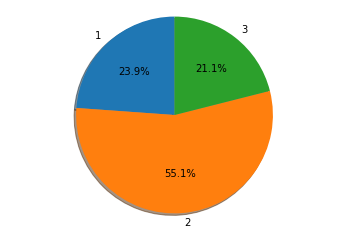

In [32]:
# In this part we draw the pie graph for the distribution of the data with 3 labels
import matplotlib.pyplot as plt

percentages= [np.count_nonzero(y==0),
              np.count_nonzero(y==1),
              np.count_nonzero(y==2)]
              
fig1, ax1 = plt.subplots()
ax1.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [33]:
# We creatte tensors from the numpy arrays
tensor_x = torch.Tensor(x) 
tensor_y = torch.Tensor(y).long()

#initially the data is in the form (Batch, 4Images, Width, Height, Channels)
#We then  change it to (Batch, 4Images,Channels, Width, Height )
tensor_x = torch.swapaxes(tensor_x,2,4)
tensor_x = torch.swapaxes(tensor_x,3,4)

x_train,x_test,y_train,y_test = train_test_split(tensor_x,tensor_y,test_size=0.1,stratify=tensor_y)
x_train,x_validation,y_train,y_validation = train_test_split(x_train,y_train,test_size=0.1,stratify=y_train)

print("x train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)
print("x test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)
print("x validation shape: ", x_validation.shape)
print("y validation shape: ", y_validation.shape)

train_ds = TensorDataset(x_train, nn.functional.one_hot(y_train,3))
validation_ds = TensorDataset(x_validation, nn.functional.one_hot(y_validation,3))
test_ds = TensorDataset(x_test,nn.functional.one_hot(y_test,3)) 
train_dl = DataLoader(train_ds,BATCHSIZE,shuffle = True)
validation_dl = DataLoader(validation_ds,BATCHSIZE)
test_dl = DataLoader(test_ds,BATCHSIZE)
del x, y

x train shape:  torch.Size([230, 4, 3, 130, 750])
y train shape:  torch.Size([230, 1])
x test shape:  torch.Size([29, 4, 3, 130, 750])
y test shape:  torch.Size([29, 1])
x validation shape:  torch.Size([26, 4, 3, 130, 750])
y validation shape:  torch.Size([26, 1])


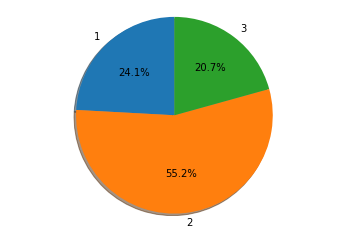

In [34]:
#The following is the distribution of the test set
#We want this to be similar to the dataset as a whole
import matplotlib.pyplot as plt

percentages= [np.count_nonzero(y_test==0),
              np.count_nonzero(y_test==1),
              np.count_nonzero(y_test==2)]
              
fig1, ax1 = plt.subplots()
ax1.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

#Classifier
The following section includes the code for the classifier.
We have support for muliple backbones. 


In [35]:
#This function takes in a model and replaces inplace relu layers to an independent relu layer
def reluToInplaceFalse(model):
  for name, child in model.named_children():
    if isinstance(child, nn.ReLU):
      setattr(child, 'inplace', False)
    else:
      reluToInplaceFalse(child)

In [36]:
#This is the classifier Class.
from torchvision.transforms.transforms import RandomRotation, RandomAdjustSharpness, RandomGrayscale

class Classifier(torch.nn.Module):

  def __init__(self, backbone='resnet', multi_backbone = False, device ="cuda:0",dropout_rate = 0.2, do_augmentation = False):
    super().__init__()
    self.multi_backbone = multi_backbone # Bool: Indicates if we use multibackbone

    #In the following secttion we download the appropriatee prettrained model
    if backbone == "vgg19":
      backbone = torchvision.models.vgg19(pretrained=True)
      self.out_channels = 25088
      
    elif backbone == "resnet18":
      backbone = torchvision.models.resnet18(pretrained=True)
      self.out_channels = 512

    elif backbone == "resnet50":
      backbone = torchvision.models.resnet50(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b1":
      backbone = torchvision.models.efficientnet_b1(pretrained=True)
      self.out_channels = 1280

    elif backbone == "Efficientnet b3":
      backbone = torchvision.models.efficientnet_b3(pretrained=True)
      self.out_channels = 1536

    elif backbone == "Efficientnet b5":
      backbone = torchvision.models.efficientnet_b5(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b7":
      backbone = torchvision.models.efficientnet_b7(pretrained=True)
      self.out_channels = 2560
      
    # Disabling inplace ReLu becasuse GradCam doesn't work it enabled
    reluToInplaceFalse(backbone)
     
    modules = list(backbone.children())[:-1]
    self.do_augmentation = do_augmentation

    if self.do_augmentation: #If augmentation is enabled we  init tthe layer
      self.augmentation = nn.Sequential(transforms.RandomHorizontalFlip(0.5),
                                        transforms.RandomVerticalFlip(0.5),
                                        # transforms.RandomPerspective(0.2),
                                        transforms.RandomCrop(size=(125,745)),
                                        transforms.RandomRotation(10, interpolation=transforms.InterpolationMode.BILINEAR),
                                        # RandomAdjustSharpness(,),
                                        # RandomGrayscale(),
                                        # transforms.RandomAutocontrast()
      )

    if self.multi_backbone: #We create the backbones and put them on the device
      self.backbone1 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone2 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone3 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone4 = nn.Sequential(*copy.deepcopy(modules)).to(device)

    else:
      self.backbone =  nn.Sequential(*modules).to(device)


    #This is the final classification layer
    self.fc = nn.Sequential(nn.Dropout(dropout_rate),
                            nn.Linear(self.out_channels * 4, 3))                
     
  def forward(self, x, is_training = True): 
    if self.do_augmentation and is_training:
      imgs = [self.augmentation(x[:,i]) for i in range(4)] #list of 4 images
    else:
      imgs = [x[:,i] for i in range(4)] #list of 4 images

    if self.multi_backbone:
      encodings = [self.backbone1(imgs[0]).flatten(1), 
                   self.backbone2(imgs[1]).flatten(1),
                   self.backbone3(imgs[2]).flatten(1),
                   self.backbone4(imgs[3]).flatten(1)]
    else:
      encodings = [self.backbone(img).flatten(1) for img in imgs]

    return self.fc(torch.cat(encodings,1))


#Training
This secttion containes the code for training the model.

## Test Model

In [37]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def test_model(model, test_dl, criterion):
  test_running_loss = 0.0
  test_running_corrects = 0
  model.eval()
  with torch.no_grad():
    for inputs, labels in test_dl:
      inputs = inputs.to(device, non_blocking = True)
      labels = labels.to(device, non_blocking = True)
      labels = labels.squeeze(1)
      outputs = model(inputs,is_training=False)
      loss = criterion(outputs, labels.float())
      _, preds = torch.max(outputs, 1)


      test_running_loss += loss.item() * inputs.size(0)
      test_running_corrects += torch.sum(preds == torch.argmax(labels,1))
  
  eval_loss = test_running_loss / len(test_dl.dataset)
  eval_acc = test_running_corrects.double() / len(test_dl.dataset)
  return eval_loss, eval_acc


## Training  with linear probing-fine tuning

https://arxiv.org/abs/2202.10054

In [38]:
# Freeze the pretrained backbone for linear probing - fine tuning
def freeze_backbone(model):
  # freeze all layers
  if model.multi_backbone:
    for param in model.backbone1.parameters():
      param.requires_grad = False

    for param in model.backbone2.parameters():
      param.requires_grad = False

    for param in model.backbone3.parameters():
      param.requires_grad = False

    for param in model.backbone4.parameters():
      param.requires_grad = False
  else:
    for param in model.backbone.parameters():
      param.requires_grad = False
  # unfreeze linear layers
  model.fc.requires_grad = True

def unfreeze_backbone(model):
  if model.multi_backbone:
    for param in model.backbone1.parameters():
      param.requires_grad = True

    for param in model.backbone2.parameters():
      param.requires_grad = True

    for param in model.backbone3.parameters():
      param.requires_grad = True

    for param in model.backbone4.parameters():
      param.requires_grad = True
  else:
    for param in model.backbone.parameters():
      param.requires_grad = True

In [39]:

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


# Based on the technique described in this paper
# https://arxiv.org/abs/2202.10054
def train_model_lpft(model, train_dl, validation_dl, test_dl, lr, weight_decay, evaluation_steps = 20, epochs = 1, savefile='model_' + datetime.today().strftime('%Y-%m-%d %H:%M:%S') + '.pt'):
  writer = SummaryWriter('runs/lpft/' + savefile)

  best_validate_acc = 0
  best_validate_loss = float('inf')
  best_validate_loss_step = 0
  final_validate_loss = 0
  final_validate_acc = 0

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  freeze_backbone(model)

  step = 0
  for epoch in tqdm(range(epochs)):
    #print(f'Epoch : {epoch}')
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels, in train_dl:
      inputs = inputs.to(device, non_blocking = True)
      labels = labels.to(device, non_blocking = True)
      labels = labels.squeeze(1)
      model.train()
      optimizer.zero_grad()
      step += 1
      outputs = model(inputs)

      preds = torch.argmax(outputs, 1)
      loss = criterion(outputs, labels.float())
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == torch.argmax(labels, 1))

      if step % evaluation_steps == 0:
        validate_loss, validate_acc = test_model(model, validation_dl, criterion)
        writer.add_scalar('Loss/validation', validate_loss, step)
        writer.add_scalar('Accuracy/validation', validate_acc, step)

        if validate_loss < best_validate_loss:
          best_validate_loss = validate_loss
          best_validate_loss_step = step
          best_validate_acc = validate_acc
          torch.save(model, savefile)

        final_validate_loss = validate_loss
        final_validate_acc = validate_acc

    epoch_loss = running_loss / len(train_dl.dataset)
    epoch_acc = running_corrects.double() / len(train_dl.dataset)
    writer.add_scalar('Loss/train', epoch_loss, step)
    writer.add_scalar('Accuracy/train', epoch_acc, step)
    
    final_train_loss = epoch_loss
    final_train_acc = epoch_acc


  test_loss, test_acc = test_model(torch.load(savefile), test_dl, criterion)
  return {  "Test Acc": test_acc.cpu().item(),
            "Test Loss": test_loss,
            "Best Validate Acc": best_validate_acc.cpu().item(),
            "Best Validate Loss": best_validate_loss,
            "Best Validate Step": best_validate_loss_step,
            "Final Train Acc": final_train_acc.cpu().item(),
            "Final Eval Acc": final_validate_acc.cpu().item(),
            "Final Train Loss": final_train_loss,
            "Final Eval Loss": final_validate_loss,
        }

In [40]:
# model = Classifier(dropout_rate=0.5,backbone=BACKBONE,multi_backbone=MULTI_BACKBONE).to(device)
# train_model_lpft(model, train_dl, validation_dl, test_dl, LR, 1e-5, epochs=10, savefile = 'model_lpft.pt')

In [41]:
#This part of the code runs multiple trainings on multiple combination on 
#specified hyperparameters for hyper-parameter tuning 

Sweep_Summary = {
    "Model" : [],
    "Backbone" : [],
    "Multi Backbone": [],
    "Optim" : [],
    "LR" : [],
    "Scheduler" : [],
    "Epochs" : [],
    "Batch Size" : [],
    "Dropout": [],
    "Augmentation": [],
    "Weight Decay": [],
    "Test Loss": [],
    "Test Acc": [],
    "Best Validate Loss": [],
    "Best Validate Step": [],
    "Best Validate Acc": [],
    "Final Train Acc": [],
    "Final Eval Acc": [],
    "Final Train Loss": [],
    "Final Eval Loss": [],

}

for weight_decay in WEIGHT_DECAY:
  for dropout_rate in DROPOUT:
    print("Weight Decay {} ".format(weight_decay))
    print("Dropout Rate {} \n------------------------------------------------------".format(dropout_rate))
    model_name = 'model{}{}.'.format(weight_decay,dropout_rate) + datetime.today().strftime('%Y-%m-%d %H:%M:%S') + '.pt'
    model = Classifier(dropout_rate=dropout_rate,backbone=BACKBONE,multi_backbone=MULTI_BACKBONE, do_augmentation=AUGMENTATION).to(device)
    summary = train_model_lpft(model,train_dl,validation_dl,test_dl,LR, weight_decay,epochs=EPOCHS,savefile=model_name)

    Sweep_Summary["Model"].append(model_name)
    Sweep_Summary["Backbone"].append(BACKBONE)
    Sweep_Summary["Optim"].append(OPTIM)
    Sweep_Summary["LR"].append(LR)
    Sweep_Summary["Scheduler"].append(SCHEDULER)      
    Sweep_Summary["Epochs"].append(EPOCHS)
    Sweep_Summary["Batch Size"].append(BATCHSIZE)
    Sweep_Summary["Dropout"].append(dropout_rate)
    Sweep_Summary["Augmentation"].append(AUGMENTATION)
    Sweep_Summary["Weight Decay"].append(weight_decay)
    Sweep_Summary["Multi Backbone"].append(MULTI_BACKBONE)
    for key,value in summary.items():
      Sweep_Summary[key].append(value)

Weight Decay 1e-05 
Dropout Rate 0.5 
------------------------------------------------------


100%|██████████| 120/120 [1:24:08<00:00, 42.07s/it]


In [42]:
# We save the results of the training sweep
sweep_name = 'Fish_Classifier_Sweep_Results_lpft' + datetime.today().strftime('%Y-%m-%d %H:%M:%S') + '.csv'
df = pd.DataFrame(Sweep_Summary)
df.to_csv(sweep_name)
!cp "{sweep_name}" "/content/drive/MyDrive"
df

,Model,Backbone,Multi Backbone,Optim,LR,Scheduler,Epochs,Batch Size,Dropout,Augmentation,Weight Decay,Test Loss,Test Acc,Best Validate Loss,Best Validate Step,Best Validate Acc,Final Train Acc,Final Eval Acc,Final Train Loss,Final Eval Loss
0,model1e-050.5.2022-05-11 07:31:54.pt,Efficientnet b7,True,Adam,0.00005,None,120,4,0.5,True,0.00001,1.010604,0.551724,1.012667,6280,0.538462,0.613043,0.538462,0.877589,1.013843


In [51]:
# Save models
!cp model*.pt "/content/drive/MyDrive/Models"

In [ ]:
!mv runs/lpft/* "/content/drive/MyDrive/runs/lpft/"
%reload_ext tensorboard
%tensorboard --logdir drive/MyDrive/runs/lpft/

#Evaluation
In this section we load the ttrained model and test it.

In [45]:
# Test model loading
def eval_model(model, dl):
  model.eval()
  test_running_loss = 0.0
  all_preds = []
  all_labels = []
  criterion = nn.BCEWithLogitsLoss()
  with torch.no_grad():
    for inputs, labels in dl:
      inputs = inputs.to(device)
      labels = labels.to(device)
      labels = labels.squeeze(1)
      outputs = model(inputs,is_training=False)
      loss = criterion(outputs, labels.float())
      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().tolist())
      all_labels.extend([label for label in labels.cpu().tolist()])
      test_running_loss += loss.item() * inputs.size(0)

  all_preds = np.array(all_preds)
  all_labels = np.argmax(all_labels, axis = 1)

  eval_loss = test_running_loss / len(dl.dataset)
  eval_acc = accuracy_score(all_labels, all_preds)
  print('{} Loss: {:.4f} Acc: {:.4f}'.format("Eval", eval_loss, eval_acc))
  print(f'Pred: {all_preds}')
  print(f'True: {all_labels}')
  print('Confusion Matrix:')
  print(confusion_matrix(all_labels, all_preds))

TRAINED_MODEL_PATH = '/content/model1e-050.5.2022-05-11 07:31:54.pt'
saved_model = torch.load(TRAINED_MODEL_PATH)
print("Test:")
eval_model(saved_model, test_dl)
loss, acc = test_model(saved_model, test_dl, nn.BCEWithLogitsLoss())
print(f'Loss: {loss}, Acc: {acc}')
print("\nValidation:")
eval_model(saved_model, validation_dl)
loss, acc = test_model(saved_model, validation_dl, nn.BCEWithLogitsLoss())
print(f'Loss: {loss}, Acc: {acc}')
print("\nTrain:")
eval_model(saved_model, train_dl)
loss, acc = test_model(saved_model, train_dl, nn.BCEWithLogitsLoss())
print(f'Loss: {loss}, Acc: {acc}')

Test:
Eval Loss: 0.6600 Acc: 0.5517
Pred: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True: [1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 2 1 0 1 2 1 2 2 0 1 1 2 1 2]
Confusion Matrix:
[[ 0  7  0]
 [ 0 16  0]
 [ 0  6  0]]
Loss: 0.660002720767054, Acc: 0.5517241379310345

Validation:
Eval Loss: 0.6632 Acc: 0.5385
Pred: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True: [1 1 2 2 1 1 0 0 2 1 0 0 2 1 1 1 2 1 1 0 1 0 2 1 1 1]
Confusion Matrix:
[[ 0  6  0]
 [ 0 14  0]
 [ 0  6  0]]
Loss: 0.663246173125047, Acc: 0.5384615384615385

Train:
Eval Loss: 0.6226 Acc: 0.5826
Pred: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 1 1 0 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1

In [ ]:
from torchsummary import summary
torch.cuda.empty_cache()
model = Classifier(dropout_rate=dropout_rate,backbone=BACKBONE,multi_backbone=True).to(device)
summary(model, (4, 3, 200, 1000))